# Семинар по методам интеллектуального анализа данных
## Введение в сверточные нейронные сети и библиотеку Tensorflow 2.0

Содержание
- Задача классификации изображений
- Линейный классификатор
- Функция потерь, обучение линейного классификатора
- Сверточный слой нейросети
- Задачи, решаемые сверточными нейросетями

Отличный курс по нейросетям (видео лекций и материалы по курсу):

CS231n: Convolutional Neural Networks for Visual Recognition (Stanford)

http://cs231n.stanford.edu/

### Библиотека Tensorflow

<img align=left src="img/tf_logo.png">

https://www.tensorflow.org/

Другие библиотеки для обучения нейросетей (глубокого обучения - Deep learning):
- PyTorch https://pytorch.org/
- Apache MXNet https://mxnet.apache.org/
- Caffe2 https://caffe2.ai/

In [1]:
%matplotlib inline
import sys
import tensorflow as tf
import pickle
import numpy as np
from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt

print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)
print('Numpy version:', np.__version__)
print('Matplotlib version', matplotlib.__version__)

Python version: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Tensorflow version: 2.0.0-alpha0
Numpy version: 1.16.2
Matplotlib version 3.0.3


In [2]:
# PATHS
PATH_CIFAR = Path('data') / 'cifar-10-batches-py'

### Задача классификации изображений

Пусть имеется набор изображений с известными метками классов (кошка, собака, машина и т.п.). Необходимо составить алгоритм, который будет определять метку класса для нового изображения. Наиболее известным набором размеченных изображений, на котором сравнивается качество разных алгоримов, является ImageNet, содержащий более 14 миллионов картинок, разделенных на 20000 классов.

Примеры изображений ImageNet:

![Imagenet_sample1](img/imagenet_sample1.jpg)
![Imagenet_sample1](img/imagenet_sample2.jpg)

Ежегодно проводится соревнование ImageNet Large Scale Visual Recognition Challenge (ILSVRC), где используется малая часть ImageNet (1.4 млн изображений, 1000 классов). В настоящее время нейросети показывают наилучшие результаты при решении этой задачи.

![Imagenet_winner_history](img/ILSVRC_winners.png)

- Deng et al, ImageNet: A Large-Scale Hierarchical Image Database, 2009.

Сети для классификации изображений ImageNet тренируются несколько дней. Чтобы уменьшить объем вычислений, мы будем использовать набор данных поменьше - **CIFAR**, который включает 10 классов, 50000 тренировочных и 10000 тестовых изображений.

CIFAR-10 можно загрузить по ссылке: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz и необходимо распаковать в папку data.

Изображения из набора данных CIFAR-10:

![CIRAR](img/cifar_classes.png)

In [3]:
def get_cifar10():
    CIFAR_DIM = (3, 32, 32)
    path_meta = PATH_CIFAR / 'batches.meta'
    paths_batches = [
        PATH_CIFAR / 'data_batch_1',
        PATH_CIFAR / 'data_batch_2',
        PATH_CIFAR / 'data_batch_3',
        PATH_CIFAR / 'data_batch_4',
        PATH_CIFAR / 'data_batch_5',    
    ]
    path_test = PATH_CIFAR / 'test_batch'
    
    # Train
    cifar10_train = {'data': [], 'labels': []}
    for path in paths_batches:
        with open(path, 'rb') as file:
            x = pickle.load(file, encoding='bytes')
            cifar10_train['data'].append(x[b'data'])
            cifar10_train['labels'].append(x[b'labels'])
    cifar10_train['data'] = np.concatenate(cifar10_train['data'])
    cifar10_train['data'] = cifar10_train['data'].reshape(-1, *CIFAR_DIM).transpose(0, 2, 3, 1)
    cifar10_train['labels'] = np.concatenate(cifar10_train['labels'])
    
    # Test
    cifar10_test = {}
    with open(path_test, 'rb') as file:
        x = pickle.load(file, encoding='bytes')
        cifar10_test['data'] = x[b'data'].reshape(-1, *CIFAR_DIM).transpose(0, 2, 3, 1)
        cifar10_test['labels'] = np.array(x[b'labels'], dtype=np.int8)
    
    # Class names
    with open(path_meta, 'rb') as file:
        class_names = [bytes_name.decode() for bytes_name 
                       in pickle.load(file, encoding='bytes')[b'label_names']]
    
    return cifar10_train, cifar10_test, class_names

In [4]:
# Загрузим датасет CIFAR10
cifar10_train, cifar10_test, class_names = get_cifar10()

cifar10_train_size = cifar10_train['data'].shape[0]
cifar10_test_size = cifar10_test['data'].shape[0]

print('Имена классов:', class_names)
print('Размер тренировочных данных:', cifar10_train_size)
assert cifar10_train_size == cifar10_train['labels'].size
print('Размер тестовых данных:', cifar10_test_size)
assert cifar10_test_size == cifar10_test['labels'].size
print('Размер изображения: {} (32x32x3)'.format(cifar10_train['data'].shape[1]))

Имена классов: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Размер тренировочных данных: 50000
Размер тестовых данных: 10000
Размер изображения: 32 (32x32x3)


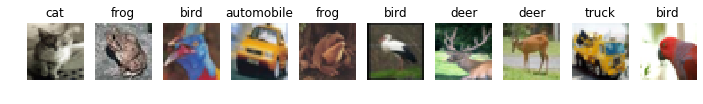

In [5]:
# Построим 10 случайных изображений CIFAR
def plot_cifar_imgs(imgs, labels):
    plt.figure(figsize=(len(imgs) + 2, 3))
    for img_num, (img, lbl) in enumerate(zip(imgs, labels), 1):
        plt.subplot(1, len(imgs), img_num)
        plt.imshow(img)
        plt.title(class_names[lbl])
        plt.axis('off')

show_idxs = np.random.randint(0, cifar10_train_size, size=10)
images = [cifar10_train['data'][idx] for idx in show_idxs]
labels = [cifar10_train['labels'][idx] for idx in show_idxs]
plot_cifar_imgs(images, labels)

In [89]:
# Посмотрим на распредление классов
print(np.unique(cifar10_train['labels'], return_counts=True)[1])
print(np.unique(cifar10_test['labels'], return_counts=True)[1])

[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


Видно, что изображения CIFAR10 распределены по классам равномерно.

### Обучение однослойной нейросети
В основе нейросети лежит линейная функция (простейший классификатор):

$$y = Wx + b,$$

где $x$ - входной вектор $\mathbb{R}^N$, $y$ - выходной вектор  $\mathbb{R}^M$, $W$ - матрица весов $\mathbb{R}^{M \times N}$, $b$ - вектор смещений $\mathbb{R}^M$.

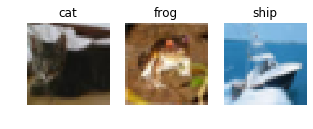

In [6]:
# Возмем 3 изображения разных классов
labels = [3, 6, 8]
images = np.stack([cifar10_train['data'][np.where(cifar10_train['labels'] == lbl)[0][0]] for lbl in labels])
plot_cifar_imgs(images, labels)

In [7]:
# Представим изображения в виде векторов длинной 3072 = 32x32x3
images = images.reshape(3, -1)

In [8]:
# Создадим случайную матрицу весов и вектор смещений
n = images[0].shape[0]
m = 10  # 10 классов
weights = tf.random.normal((m, n)) / 100
bias = tf.random.normal((m, ))

In [9]:
# Применим линейную функцию к изображениям
# images - numpy массив, weights - tensorflow массив, но их можно перемножать
y = images @ tf.transpose(weights) + bias  # @ - умножение матриц (== tf.matmul)
print(y)  # получается tensorflow массив

tf.Tensor(
[[  -6.5521264  -65.75461     -7.6227465   37.98676    -65.283775
     6.6298523   35.0437     -42.607082    -8.631969   -37.641396 ]
 [ -40.042355   -48.254227   -70.513794   -26.883457   -89.08337
    43.884132   -57.794846     8.830553    21.09018   -221.28424  ]
 [  -9.295894   -87.66952    -53.05158      6.7628098 -172.27931
   -27.069271    50.68219    -58.066475   -11.965881  -139.93343  ]], shape=(3, 10), dtype=float32)


Каждое число (или score) можно интерпретировать, как принадлежность каждого изображения к одному из 10 классов. Тот индекс, где score наибольший и есть предсказанный класс.

In [10]:
predictions = tf.argmax(y, axis=1)
for true_label, prediction in zip(labels, predictions):
    print('Предсказание для изображения {}: {}'
          ''.format(class_names[true_label], class_names[prediction]))

Предсказание для изображения cat: cat
Предсказание для изображения frog: dog
Предсказание для изображения ship: frog


Так как веса случайны, мы получаем случайное предсказание. Чтобы найти веса, которые позволят разделять классы необходимо  ввести функцию потерь, которая будет штрафовать классификатор за неверные предсказания классов. Один из вариатов таких функций является Hinge loss, которая применятся в методе опорных векторов (SVM):

$$L = \max(0, 1 + \max\limits_{i\neq t}(y_i - y_t)),$$

$y_t$ - значения предсказания для истинного класса. Если максимальное значение среди предсказаний соотсветствует истинному классу, значение функции потерь равно0, если другому классу, то $L > 0$.

In [77]:
# В Tensorflow 2.0 функции потерь находяться в модуле tf.losses
hinge_loss = tf.losses.CategoricalHinge()

# Однако на вход функции необходимо подавать не индексы классов, 
# а вектор 0 и 1 длиной 10 (например, 3 класс преобразуется в [0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
# Это называется one-hot-encoding
one_hot_labels = tf.one_hot(labels, depth=10)
print('Закодированные метки классов:\n{}\n'.format(one_hot_labels))
loss = hinge_loss(one_hot_labels, y)
print('Значение функции потерь (усреднение по трем предсказаниям): {:.2f}'.format(loss.numpy().item()))

Закодированные метки классов:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

Значение функции потерь (усреднение по трем предсказаниям): 55.44


Hinge loss - выпуклая, но недифференцируемая функция, однако при минимизации этим пренебрегают. Теперь мы может использовать простейший градиентый спуск для того чтобы найти оптимальные весовые коэффициенты.

Конечно в tensorflow есть более простые способы для минизации функции потерь.

Чаще в качестве функции потерь для задачи определения меток взаимоисключающих классов используется перекрестная энтропия (cross-entropy loss). Метки классов - это вектор нулей и единиц (например, кошка в CIFAR-10 - [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]). Вектор можно интерпретировать как вероятность принадлежности к классу, поэтому удобно, когда выходные значения нейросети тоже представляют собой вероятности.

Функция softmax позволяет отнормировать предсказания линейного слоя ($y$) и получить подобие вероятностного распределения:

$$z = \sigma(y)_i = \frac{e^{y_i}}{\sum\limits_{k=1}^K e^{y_k}}$$

Cross-entropy loss - это функция потерь, которая исользует истинное и предсказанное распределение классов:

$$L = \frac{1}{N} \sum\limits_{n=1}^N H(p_n, q_n)
    = -\frac{1}{N} \sum\limits_{n=1}^N [z_n \log \hat{z}_n + (1 - z_n)\log(1 - \hat{z}_n)],$$
    
где $p$ - истинное распределение классов, $q$ - распределение, предсказанное моделью. Чем больше предсказанная вероятность для истинного класса, тем меньше значение функции потерь. Однако, как видно из формулы, если модель предскажет 1 там, где должен быть 0, функция потерь $L = \infty$. Это приводит к тому, что модели, обученные с помощью перекрестной энтропии, никогда не уверенны до конца в своих предсказаниях.

Линейный классификатор можно интерпретировать как поверхность, разделяющую разные классы в многомерном прострастве, определяемым размерностью входного вектора.

CIFAR, ImageNET, нейрон, перцептрон, функции потерь, градиентный спуск, обратное распространение ошибки, сверточные сети, пуллинг, батч-нормализация

Входные фильтры нейросетей (7х7)

## Задачи, решаемые сверточными нейросетями
- Классификация изображений
- Сегментация (instance и semantic segmentation)
- Подсчет объектов